In [2]:
import pandas as pd 
import numpy as np 
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir("/home/blue/code/graph_permutation")

In [3]:
edges_df = pd.read_csv("data/edges.csv", index_col=0)
node_df = pd.read_csv("data/nodes.csv")
base_graph = nx.Graph()
base_graph.add_edges_from(zip(edges_df.src, edges_df.dst))
n_nodes = len(base_graph.nodes)
n_edges = len(base_graph.edges)
cancer_proteins = node_df[node_df.is_cancer_protein].node_name

In [4]:
cancer_one_hop_set = set()
for cancer_protein in cancer_proteins:
    neighbors = set(dict(base_graph[cancer_protein]).keys())
    cancer_one_hop_set = cancer_one_hop_set.union(neighbors)

In [5]:
# K-3 motif
cancer_one_hop_subgraph = base_graph.subgraph(cancer_one_hop_set)
cancer_one_hop_arr = np.array(cancer_one_hop_subgraph.nodes)
cancer_proteins_in_subnetwork = cancer_proteins[cancer_proteins.isin(cancer_one_hop_arr)]
count = 0
motif_list = []
for n1 in cancer_proteins_in_subnetwork:
    for n2 in cancer_one_hop_subgraph[n1]:
        for n3 in cancer_one_hop_subgraph[n2]:
            if n1 in cancer_one_hop_subgraph[n3]:
                motif_list.append((n1, n2, n3))
                count += 1
count

5231092

In [6]:
# 去除重複的 A-B-C = A-C-B 利用set完成排序後去除
deduplicate_motif_list = set([tuple(set(motif)) for motif in motif_list])
motif_df = pd.DataFrame(deduplicate_motif_list, columns=["n1", "n2", "n3"])
motif_df.head()
motif_df.to_csv("output/motif.csv")

In [7]:
# motif 的邊列表
motif_edges_df = pd.DataFrame(columns=["n1n2", "n2n3", "n3n1"])
motif_edges_df["n1n2"] = motif_df.n1 + "-" + motif_df.n2 
motif_edges_df["n2n3"] = motif_df.n2 + "-" + motif_df.n3
motif_edges_df["n3n1"] = motif_df.n3 + "-" + motif_df.n1 
motif_edges_df.to_csv("output/motif_edges_df.csv")

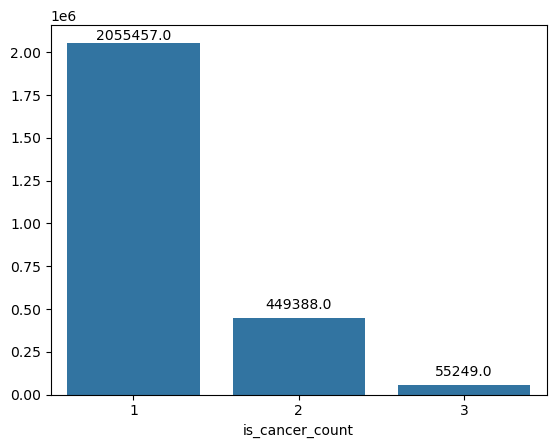

In [9]:
# 查看k-3 motif 的不同模式數量並繪圖
motif_df["is_cancer_count"] = motif_df.isin(cancer_proteins.values).sum(axis=1)
size = motif_df.groupby("is_cancer_count").size()

ax = sns.barplot(size)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()*0.98),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


In [77]:
result_dict = {}
for i in motif_df.index:
    result_dict[i] = []

In [12]:
import json

In [19]:
n_permutation = 1000
node_dict = node_df.node_name.to_dict()
#result_df = pd.DataFrame(index=motif_df.index)

result_dict = {}
for i in motif_edges_df.index:
    result_dict[i] = []

n_permutation = 2
for i in range(n_permutation):
    print(i, end=",")
    random_graph = nx.gnm_random_graph(n_nodes, n_edges)
    random_graph = nx.relabel_nodes(random_graph, node_dict) # 重抓1-hop subgraph
    random_one_hop_subgraph = nx.subgraph(random_graph, cancer_one_hop_set)
    random_edge_df = pd.DataFrame(random_one_hop_subgraph.edges, columns=["src", "dst"])
    # random_edge_df["edge"] = random_edge_df.src + "-" + random_edge_df.dst 
    #result_df[i] = motif_edges_df.isin(random_edge_df.edge.values).all(axis=1)
    edge_arr = random_edge_df.src + "-" + random_edge_df.dst 
    mask = motif_edges_df.isin(edge_arr).all(axis=1)
    for motif_index in motif_edges_df[mask].index:
        result_dict[motif_index] = i
    #if i % 100 == 0:
    #    result_df.to_csv(f"output/motif_permutation/result{i}.csv")
    #    result_df = pd.DataFrame(index=motif_df.index)

with open(f"output/result_dict.json", 'w') as json_file:
    json.dump(result_dict, json_file)



0,1,

In [21]:
motif_edges_df

,n1n2,n2n3,n3n1
0,ENSP00000418082-ENSP00000359345,ENSP00000359345-ENSP00000426167,ENSP00000426167-ENSP00000418082
1,ENSP00000354558-ENSP00000216442,ENSP00000216442-ENSP00000457870,ENSP00000457870-ENSP00000354558
2,ENSP00000384675-ENSP00000391592,ENSP00000391592-ENSP00000244007,ENSP00000244007-ENSP00000384675
3,ENSP00000261776-ENSP00000501150,ENSP00000501150-ENSP00000262866,ENSP00000262866-ENSP00000261776
4,ENSP00000430684-ENSP00000495360,ENSP00000495360-ENSP00000385216,ENSP00000385216-ENSP00000430684
...,...,...,...
2560089,ENSP00000358635-ENSP00000281043,ENSP00000281043-ENSP00000375730,ENSP00000375730-ENSP00000358635
2560090,ENSP00000269305-ENSP00000346027,ENSP00000346027-ENSP00000320171,ENSP00000320171-ENSP00000269305
2560091,ENSP00000331901-ENSP00000393596,ENSP00000393596-ENSP00000479606,ENSP00000479606-ENSP00000331901
2560092,ENSP00000395574-ENSP00000346027,ENSP00000346027-ENSP00000009530,ENSP00000009530-ENSP00000395574


In [17]:
for k, v in result_dict.items():
    if v != []:
        print(v)

In [79]:
# permutation
# 1
n_permutation = 1000
node_dict = node_df.node_name.to_dict()
result_df = pd.DataFrame(index=motif_df.index)

for i in tqdm(range(n_permutation)):
    random_graph = nx.gnm_random_graph(n_nodes, n_edges)
    random_graph = nx.relabel_nodes(random_graph, node_dict) # 重抓1-hop subgraph
    random_one_hop_subgraph = nx.subgraph(random_graph, cancer_one_hop_set)
    random_edge_df = pd.DataFrame(random_one_hop_subgraph.edges, columns=["src", "dst"])
    random_edge_df["edge"] = random_edge_df.src + "-" + random_edge_df.dst 
    result_df[i] = motif_edges_df.isin(random_edge_df.edge.values).all(axis=1)
    #exist_motifs_indices = motif_edges_df[motif_edges_df.isin(random_edge_df.edge.values).all(axis=1)].index
    
    #for j in exist_motifs_indices:
    #    result_dict[j].append(i)
    if i % 100 == 0:
        result_df.to_csv(f"output/motif_permutation/result{i}.csv")
        result_df = pd.DataFrame(index=motif_df.index)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


In [ ]:
# 3
n_permutation = 10

result_label_swap = result_df(n_permutation)
for i in tqdm(range(n_permutation)):
    is_cancer_protein = node_df.is_cancer_protein.values.copy()
    np.random.shuffle(is_cancer_protein)
    random_node_df = node_df.copy()
    random_node_df.is_cancer_protein = is_cancer_protein
    random_node_df[random_node_df.is_cancer_protein]
    base_graph
    result_label_swap.iloc[i, :] = cal_info(base_graph, random_sub_df)
result_label_swap.to_csv("output/label_swap.csv")

In [34]:
is_cancer_protein = node_df.is_cancer_protein.values.copy()
np.random.shuffle(is_cancer_protein)
is_cancer_protein

array([False, False, False, ..., False, False, False])

In [56]:
result_df = pd.DataFrame(index=motif_df.index)
n_cancer_nodes = node_df.is_cancer_protein.sum()
n_permutation = 10
for i in range(n_permutation):
    # 隨機挑n_cancer_nodes個當作是cancer gene
    random_cancer_proteins = np.random.choice(node_df.node_name, 
                                             size=n_cancer_nodes, 
                                             replace=False)
    # 找出one hop
    random_cancer_one_hop_set = set()
    for cancer_protein in cancer_proteins:
        neighbors = set(dict(base_graph[cancer_protein]).keys())
        random_cancer_one_hop_set = random_cancer_one_hop_set.union(neighbors)                       
    random_one_hop_subgraph = base_graph.subgraph(random_cancer_one_hop_set)
    random_edge_df = pd.DataFrame(random_one_hop_subgraph.edges, columns=["src", "dst"])
    random_edge_df["edge"] = edges.src + "-" + edges.dst
    result_df[i] = motif_edges_df.isin(random_edge_df.edge.values).all(axis=1)
result_df

,0,1,2,3,4,5,6,7,8,9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2554946,False,False,False,False,False,False,False,False,False,False
2554947,False,False,False,False,False,False,False,False,False,False
2554948,False,False,False,False,False,False,False,False,False,False
2554949,False,False,False,False,False,False,False,False,False,False
